# Generate initial and time-varying nudging profiles

### Code to generate ONLY initial and time-varying profile forcing based on ERA5 along backward trajectory for COMBLE LES/SCM intercomparison
### Developed by Tim Juliano at NCAR/RAL originally on 8/26/22
### This file generated for the ARM Data Archive on 2/1/23
### We have the option of starting as far as 28 hours before arriving at Andenes (03/12/20 at 14 UTC)
### Includes lat/lon correction by Peng Wu (PNNL)
#### NOTE: NO O3 INFORMATION IN FILE RIGHT NOW, WILL ADD LATER
#### NOTE: ONLY NUDGING FOR NOW, AM NOT COMPUTING GEOSTROPHIC WIND PROFILES

### Import libraries

In [70]:
import netCDF4
import numpy as np
import numpy.ma as ma
import sys
from netCDF4 import Dataset, date2num,num2date
import datetime as dt
import os
import matplotlib.pyplot as plt
from scipy import interpolate
import geopy.distance
from scipy.ndimage import gaussian_filter1d
#import gdal

### !!! BEGIN USER MODS !!!
#### How many hours before ice edge do you want to start?
#### Note: t0_h = 0 means you are starting approx. at ice edge, t0_h = 10 means you are starting 10 h upstream (north) of the ice edge
#### Note: t0_h must be an integer

In [71]:
t0_h = 10
if t0_h < 0 or t0_h > 10:
    sys.exit('Error: Please set 0 <= t0_h >= 10')

### !!! END USER MODS !!!

### Set some things

In [72]:
nhrs = 18 + t0_h + 1 # total number of simulation hours, including t0; default is from 2020-03-12 at 14 UTC to 2020-03-14 at 00 UTC
if t0_h == 0:
    start_time = '2020-03-13 00:00:00'
    start_day = 13
    start_hour = 0
else:
    start_time = '2020-03-12 ' + str(24-t0_h) + ':00:00'
    start_day = 12
    start_hour = 24-t0_h
print ('Start time is: ' + start_time)

Start time is: 2020-03-12 14:00:00


### Forcing NetCDF name and delete file if already exists

In [73]:
savename = 'COMBLE_INTERCOMPARISON_NUDGING_FORCING_NEW.nc'

if os.path.exists(savename):
    os.remove(savename)
    print('The file ' + savename + ' has been deleted successfully')

### Get LES domain locations

In [74]:
fname = 'LES_domain_location_28h_18Z_Mar13_2020.txt'

les_loc = np.loadtxt(fname,skiprows=1)
les_hh = les_loc[:,0]
les_hh_idx = np.where(les_hh>=-1.*t0_h)[0]
les_lat = les_loc[les_hh_idx,1]
les_lon = les_loc[les_hh_idx,2]

les_lat_mid = round(np.mean(les_lat),1)
les_lon_mid = round(np.mean(les_lon),1)
print ('LES domain mid point: ' + 'lat=' + str(les_lat_mid) + 'N, lon=' + str(les_lon_mid) + 'E')

LES domain mid point: lat=77.6N, lon=8.6E


### Create vertical grid
#### 160 vertical grid levels, defined at the cell faces

In [75]:
nz = 160

dz_grid = np.empty(nz-1)
dz_grid[0] = 20.0
dz_grid[1] = 25.0
dz_grid[2] = 30.0
dz_grid[3] = 35.0
dz_grid[4:140] = 40.0
dz_grid[140] = 60.0
dz_grid[141:157] = 80.0
dz_grid[157] = 60.0
dz_grid[158] = 50.0

z_grid = np.empty(nz)
z_grid[0] = 0.0
for i in np.arange(1,len(z_grid)):
    z_grid[i] = z_grid[i-1] + dz_grid[i-1]

### Read in data from ERA5 backtrajectory (netCDF)

In [76]:
# File name
fname = 'theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc'

# Open dataset
dataset = netCDF4.Dataset(fname, "r")

# Read variables (1D arrays are time, 2D arrays are time x pressure level)
hours = dataset.variables['Time'][:]
lat = dataset.variables['Latitude'][:]
lon = dataset.variables['Longitude'][:]
pres = dataset.variables['Pressure'][:]
sfc_pres = dataset.variables['SfcPres'][:]
sst = dataset.variables['SST'][:]
hgt = dataset.variables['GEOS_HT'][:,:]
uwnd = dataset.variables['U'][:,:]
vwnd = dataset.variables['V'][:,:]
wwnd = dataset.variables['W'][:,:]
temp = dataset.variables['Temp'][:,:]
theta = dataset.variables['Theta'][:,:]
qv = dataset.variables['SH'][:,:]

### Convert units

In [77]:
sfc_pres_pa = sfc_pres/100.  # Pa to hPa
pres_pa = pres*100.          # hPa to Pa

### Reverse time dimension of 2D arrays, as well as sfc pressure and sst, so that beginning of backward trajectory is in first position

In [78]:
hgt = np.flip(hgt,axis=0)
uwnd = np.flip(uwnd,axis=0)
vwnd = np.flip(vwnd,axis=0)
wwnd = np.flip(wwnd,axis=0)
temp = np.flip(temp,axis=0)
theta = np.flip(theta,axis=0)
qv = np.flip(qv,axis=0)
sfc_pres_pa = sfc_pres_pa[::-1]
sst = sst[::-1]

### Unmask sst field and get index according to t0_h (furthest north we can go is 28h after backtrajectory initialization from Andenes, or 3/12/20 at 14 UTC)

In [79]:
sst_real = ma.getdata(sst)
loopidx = np.where(sst_real>0.0)[0]
t0 = loopidx[10-t0_h]

### Calculate sfc potential temperature

In [80]:
theta1000mb = theta[:,0]
sfc_theta = theta1000mb*pow((1000./sfc_pres_pa),0.286)

### Get information at t0

In [81]:
z1 = 0

pres_t0 = pres_pa[z1:]
hgt_t0 = hgt[t0,z1:]
uwnd_t0 = uwnd[t0,z1:]
vwnd_t0 = vwnd[t0,z1:]
wwnd_t0 = wwnd[t0,z1:]
temp_t0 = temp[t0,z1:]
theta_t0 = theta[t0,z1:]
qv_t0 = qv[t0,z1:]

ps_t0 = sfc_pres_pa[t0]
thetas_t0 = sfc_theta[t0]

### Interpolate t0 profiles and nudging profiles to common vertical grid for simplicity

#### Find time with highest first level and get vertical grid

In [82]:
zz1_nudge = np.empty([nhrs,len(pres_t0)])
count = 0
for i in np.arange(nhrs):
    zz1_nudge[count,:] = hgt[t0+i,z1:]

    count+=1

zz1_nudge_max_idx = np.argmax(zz1_nudge[:,0])
zz1_nudge_max = zz1_nudge[zz1_nudge_max_idx,0]

zgeoi = zz1_nudge[zz1_nudge_max_idx,0:-1]

print ('First level for all profiles = ' + str(round(zgeoi[0],3)) + ' m' )

First level for all profiles = 18.168 m


#### Do the linear interpolation for initial forcing profiles

In [83]:
f = interpolate.interp1d(hgt_t0, pres_t0)
pres_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, uwnd_t0)
uwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, vwnd_t0)
vwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, wwnd_t0)
wwnd_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, temp_t0)
temp_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, theta_t0)
theta_t0i = f(zgeoi)
f = interpolate.interp1d(hgt_t0, qv_t0)
qv_t0i = f(zgeoi)

#### Do the linear interpolation for nudging forcing profiles

In [84]:
unudgei = np.empty([nhrs,len(pres_t0)-1])
vnudgei = np.empty([nhrs,len(pres_t0)-1])
do_t_qv_w = True # temp flag for advection checks
if do_t_qv_w == True:
    tnudgei = np.empty([nhrs,len(pres_t0)-1])
    qvnudgei = np.empty([nhrs,len(pres_t0)-1])
    wnudgei = np.empty([nhrs,len(pres_t0)-1])
count = 0
for i in np.arange(nhrs):
    f = interpolate.interp1d(hgt[t0+i,z1:], uwnd[t0+i,z1:])
    unudgei[count,:] = f(zgeoi)
    f = interpolate.interp1d(hgt[t0+i,z1:], vwnd[t0+i,z1:])
    vnudgei[count,:] = f(zgeoi)
    
    if do_t_qv_w == True:
        f = interpolate.interp1d(hgt[t0+i,z1:], theta[t0+i,z1:])
        tnudgei[count,:] = f(zgeoi)
        
        f = interpolate.interp1d(hgt[t0+i,z1:], qv[t0+i,z1:])
        qvnudgei[count,:] = f(zgeoi)
        
        f = interpolate.interp1d(hgt[t0+i,z1:], wwnd[t0+i,z1:])
        wnudgei[count,:] = f(zgeoi)
    
    count+=1

#### Compare original and interpolated intial profiles as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

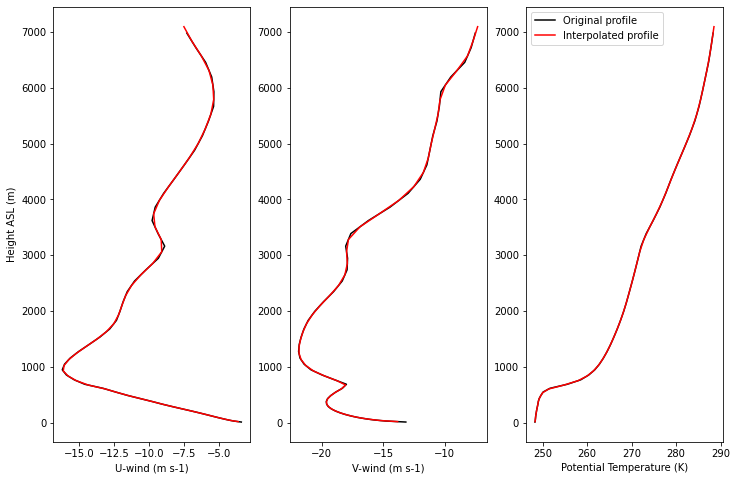

In [85]:
zplt1 = 0
zplt2 = 50

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = uwnd_t0
var_plt2 = uwnd_t0i
plt.subplot(131)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('U-wind (m s-1)')
plt.ylabel('Height ASL (m)')

var_plt1 = vwnd_t0
var_plt2 = vwnd_t0i
plt.subplot(132)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r')
plt.xlabel('V-wind (m s-1)')
        
var_plt1 = theta_t0
var_plt2 = theta_t0i
plt.subplot(133)
plt.plot(var_plt1[zplt1:zplt2],hgt_t0[zplt1:zplt2],c='k',label='Original profile')
plt.plot(var_plt2[zplt1:zplt2],zgeoi[zplt1:zplt2],c='r',label='Interpolated profile')
plt.xlabel('Potential Temperature (K)')
plt.legend()
plt.show()

#### Compare original and interpolated nudging profiles as example to show efficacy of method

<Figure size 432x288 with 0 Axes>

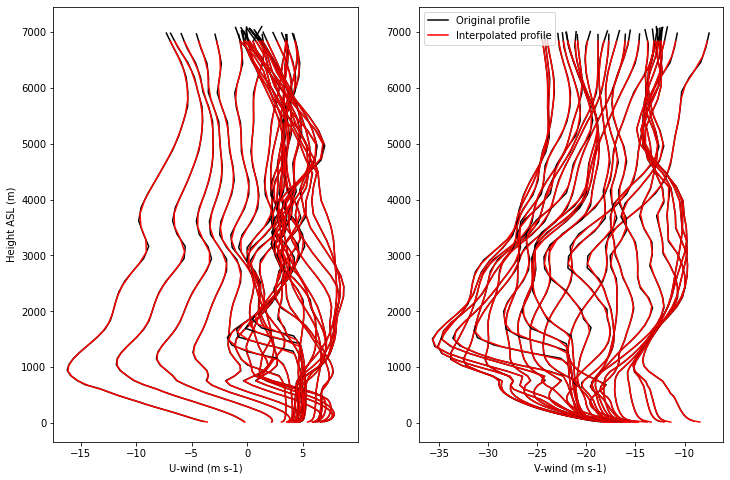

In [86]:
zplt1 = 0
zplt2 = 50

plt.figure()
plt.figure(figsize=(12,8))

var_plt1 = uwnd
var_plt2 = unudgei
plt.subplot(121)
for i in np.arange(nhrs):
    plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k')
    plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r')
plt.xlabel('U-wind (m s-1)')
plt.ylabel('Height ASL (m)')
        
var_plt1 = vwnd
var_plt2 = vnudgei
plt.subplot(122)
for i in np.arange(nhrs):
    if i == 0:
        plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k',label='Original profile')
        plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r',label='Interpolated profile')
    else:
        plt.plot(var_plt1[t0+i,zplt1+1:zplt2],hgt[t0+i,zplt1+1:zplt2],c='k')
        plt.plot(var_plt2[i,zplt1:zplt2-1],zgeoi[zplt1:zplt2-1],c='r')
plt.xlabel('V-wind (m s-1)')
plt.legend()
plt.show()

### Create new netcdf file

In [87]:
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = Dataset('./' + savename,mode='w',format='NETCDF3_CLASSIC') 
#print(ncfile)

### Create dimensions

In [88]:
levs = len(zgeoi)
z_grid_levs = len(z_grid)
t0_dim = ncfile.createDimension('t0', 1)     # initial time axis
lat_dim = ncfile.createDimension('lat', 1)     # latitude axis
lon_dim = ncfile.createDimension('lon', 1)     # longitude axis
lev_dim = ncfile.createDimension('lev', levs)      # level axis
zw_grid_dim = ncfile.createDimension('zw_grid', z_grid_levs)      # zw_grid axis
time_dim = ncfile.createDimension('time', None)    # unlimited axis (can be appended to)

### Create global attributes

In [89]:
ncfile.title='Initial and time-varying nudging profiles for 13 March 2020 COMBLE intercomparison case'
ncfile.reference='https://arm-development.github.io/comble-mip/'
ncfile.authors='Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)'
ncfile.version='Created on 2023-02-01'
ncfile.format_version='DEPHY SCM format version 1'
ncfile.script='create_comble_nudging_forcing_era5ml.ipynb'
ncfile.startDate=start_time
ncfile.endDate='2020-03-13 18:00:00'
ncfile.force_geo=1
ncfile.surfaceType='ocean'
ncfile.surfaceForcing='ts'
ncfile.lat=str(les_lat_mid) + ' deg N'
ncfile.dx='150 m'
ncfile.dy='150 m'
ncfile.dz='see zw_grid variable'
ncfile.nx='648'
ncfile.ny='648'
ncfile.nz='160'

### Create variables

#### Dimensions

In [90]:
t0_time = ncfile.createVariable('t0', np.float32, ('t0',))
t0_time.units = 'seconds since 2020-03-12 14:00:00'
t0_time.long_name = 'Initial time'

latitude = ncfile.createVariable('lat', np.float32, ('lat',))
latitude.units = 'degrees_north'
latitude.long_name = 'latitude'

longitude = ncfile.createVariable('lon', np.float32, ('lon',))
longitude.units = 'degrees_east'
longitude.long_name = 'longitude'

time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since ' + start_time
time.long_name = 'time'

lev = ncfile.createVariable('lev', np.float64, ('lev',))
lev.units = 'm'
lev.long_name = 'altitude'

#### Initial profiles

In [91]:
pressure = ncfile.createVariable('pressure', np.float64, ('t0','lev','lat','lon',))
pressure.units = 'Pa'
pressure.long_name = 'pressure'

u = ncfile.createVariable('u', np.float64, ('t0','lev','lat','lon',))
u.units = 'm s-1'
u.long_name = 'zonal wind'

v = ncfile.createVariable('v', np.float64, ('t0','lev','lat','lon',))
v.units = 'm s-1'
v.long_name = 'meridional wind'

temperature = ncfile.createVariable('temp', np.float64, ('t0','lev','lat','lon',))
temperature.units = 'K'
temperature.long_name = 'temperature'

ptemperature = ncfile.createVariable('theta', np.float64, ('t0','lev','lat','lon',))
ptemperature.units = 'K'
ptemperature.long_name = 'potential temperature'

qvapor = ncfile.createVariable('qv', np.float64, ('t0','lev','lat','lon',))
qvapor.units = 'kg kg-1'
qvapor.long_name = 'specific humidity'

#### Initial sfc conditions

In [92]:
ps = ncfile.createVariable('ps', np.float64, ('t0','lat','lon',))
ps.units = 'Pa'
ps.long_name = 'surface pressure'

thetas = ncfile.createVariable('thetas', np.float64, ('t0','lat','lon',))
thetas.units = 'K'
thetas.long_name = 'surface potential temperature'

#### Time-varying forcing - nudging

In [93]:
u_nudging = ncfile.createVariable('u_nudging', np.float64, ('time','lev',))
u_nudging.units = 'm s-1'
u_nudging.long_name = 'zonal wind profile for nudging'

v_nudging = ncfile.createVariable('v_nudging', np.float64, ('time','lev',))
v_nudging.units = 'm s-1'
v_nudging.long_name = 'meridional wind profile for nudging'

if do_t_qv_w == True:
    theta_nudging = ncfile.createVariable('theta_nudging', np.float64, ('time','lev',))
    theta_nudging.units = 'K'
    theta_nudging.long_name = 'potential temperature profile for nudging'

    qv_nudging = ncfile.createVariable('qv_nudging', np.float64, ('time','lev',))
    qv_nudging.units = 'kg kg-1'
    qv_nudging.long_name = 'specific humidity profile for nudging'
    
    w_nudging = ncfile.createVariable('w_nudging', np.float64, ('time','lev',))
    w_nudging.units = 'Pa s-1'
    w_nudging.long_name = 'vertical velocity for nudging'

#### Misc

In [94]:
zw_grid = ncfile.createVariable('zw_grid', np.float64, ('zw_grid',))
zw_grid.units = 'm'
zw_grid.long_name = 'grid altitude at cell faces'

### Write data

In [95]:
t0_time[:] = 0.0
latitude[:] = les_lat_mid
longitude[:] = les_lon_mid
lev[:] = zgeoi
zw_grid[:] = z_grid
pressure[:] = pres_t0i
u[:] = uwnd_t0i
v[:] = vwnd_t0i
temperature[:] = temp_t0i
ptemperature[:] = theta_t0i
qvapor[:] = qv_t0i

ps[:] = ps_t0
thetas[:] = thetas_t0

u_nudging[:] = unudgei
v_nudging[:] = vnudgei

if do_t_qv_w == True:
    theta_nudging[:] = tnudgei
    qv_nudging[:] = qvnudgei
    w_nudging[:] = wnudgei

### Add times

In [96]:
dates = []
for i in np.arange(nhrs):
    if nhrs == 19:
        dates.append(dt.datetime(2020,3,13,i))
    else:
        if start_hour+i > 23:
            dates.append(dt.datetime(2020,3,13,start_hour+i-24))
        else:
            dates.append(dt.datetime(2020,3,12,start_hour+i))
times = date2num(dates, time.units)
time[:] = times

### Close the file

In [97]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Forcing and initial conditions for 13 March 2020 COMBLE intercomparison case
    reference: https://arm-development.github.io/comble-mip/
    authors: Timothy W. Juliano (NCAR/RAL, tjuliano@ucar.edu); Florian Tornow (NASA/GISS, ft2544@columbia.edu); Ann M. Fridlind (NASA/GISS, ann.fridlind@nasa.gov)
    version: Created on 2023-02-01
    format_version: DEPHY SCM format version 1
    script: create_comble_nudging_forcing_era5ml.ipynb
    startDate: 2020-03-12 14:00:00
    endDate: 2020-03-13 18:00:00
    force_geo: 1
    surfaceType: ocean
    surfaceForcing: ts
    lat: 77.6 deg N
    dx: 150 m
    dy: 150 m
    dz: see zw_grid variable
    nx: 648
    ny: 648
    nz: 160
    dimensions(sizes): t0(1), lat(1), lon(1), lev(136), zw_grid(160), time(29)
    variables(dimensions): float32 t0(t0), float32 lat(lat), float32 lon(lon), float64 time(time), float64 lev(lev), float64 pressu